## Numerical Methods In Finance | fall 2024

### *Seminar 8*

In [456]:
import numpy as np
import copy
import scipy 
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt

### 1. Salvaging a linear correlation matrix

#### 1.1 Main concepts and motivation

The **linear correlation matrix $\text{C}$** of given set of assets $(S^{1}, S^{2}, \cdots, S^{n})$ is a $n \times n$ real-valued **positive-semidefinite symmetrix** matrix 

$$
\begin{align*}
\textbf{C} = 
\left(
\begin{matrix} 
c_{11} & c_{12} &  \cdots & c_{1n} \\ 
c_{21} & c_{22} & \cdots & c_{2n} \\
\vdots & \vdots & \ddots & \vdots \\ 
c_{n1} & c_{n2} & \cdots & c_{nn} \\   
\end{matrix}
\right)
\end{align*}
$$

with $c_{ij} := \text{corr}(dS^{i}/S^{i}, dS^j/S^j) = \dfrac{\text{cov}(dS^i/S^i, dS^j/S^j)}{\sigma_{dS^i/S^i} \cdot \sigma_{dS^j/S^j}}.$

Properties of correlation matrix: 

1. Positive-semidefinite and symmetric.
2. All diagonal ements are equal to $1$ and all other elements are in $[-1, 1]$ range. 


There are many reasons why a correct specification of a correlation matrix is essential in financial industry. Dealing with derivatives pricing, we have to employ the multi-dimensional **Monte-Carlo simulations** to describe the evolutions of porftolios of assets. The problem of simulation of co-dependent random variables, desrcibing the evolution of a portfolio of assets, boils down to sampling a correlated random variates with a given correlation matrix $\text{C}$.

Indeed, suppose that the goal is to generate two correlated normal variables $x_1$ and $x_2$ with given correlation coefficient $\rho$. To accomplish that, it is necessary to generate two uncorrelated normal random variables $z_1$ and $z_2$, and then let

$$x_1 = z_1, \qquad $$
$$x_2 = \rho z_1 + \sqrt{1 - \rho^2} z_2,$$

which gives us $x_1$ and $x_2$ correlated with $\rho$ coefficient normal random variables. 

In matrix form, we get that 
$$x = \text{B} \cdot z$$

with $\text{B} = \begin{pmatrix} 1 & 0\\  \rho & \sqrt{1 - \rho^2} \end{pmatrix}$, $\text{C} =  \begin{pmatrix} 1 & \rho \\  \rho & 1 \end{pmatrix}$ and $\text{C} = \text{B} \cdot \text{B}^T$.

Hence, given the sample of **independent** uniform random variates $z$, the transormation 

$$x = \text{B} \cdot z$$

gives **co-dependent** random variates $x$ with correlation matrix $\text{C} = \text{B} \cdot \text{B}^{T}.$

For that reason, we should guarantee that the constructed correlation matrix $\text{C}$ is **positive-semidefinite**! However, usually the correlation matrix built from historical data may violate this condition.

Hence, we have to establish an algorithm which allows to "salvage" the correlation matrix from being **not positive-semidefinite** and correct it in a such way to make it satisfying the desiring condtion and remain it as closer as possible to the initial one.

$$
\Large
\boxed{
\textbf{C} \text{, \underline{\underline{not}} positive-semidefinite}
} 

\quad 
\longrightarrow
\quad

\Large
\boxed{
\widetilde{\textbf{C}} \approx \textbf{C} \text{, positive-semidefinite}
} 
$$

#### 1.2 Hyphersphere decomposition

$$\widetilde{\text{C}} = \text{B} \cdot \text{B}^{T}$$

$$b_{ij} = \cos(\theta_{ij}) \cdot \prod_{k=1}^{j-1} \sin(\theta_{ik}), \qquad j=1,\dots,n-1,$$
$$b_{ij} = \prod_{k=1}^{j-1} \sin(\theta_{ik}), \qquad j = n.$$


Notice that the given matrix $\widetilde{\text{C}}$ satisfies the conditions on correlation matrix.

+  All diagonal elements of $\widetilde{\text{C}}$ are equal to $1$ and all other are in $[-1, 1]$ range.  
+ $\widetilde{\text{C}}$ is by construction positive definite and symmetric. 

It remains to guarantee that $\widetilde{\text{C}}$ is close (e.g., elementwise) to original correlation matrix $\text{C}$. For that reason, we establish an optimisation procedure 

$$\varepsilon( \theta) = \| \widetilde{\text{C}} - \text{C}\|_2 = \sum_{i,j} (\widetilde{c_{ij}}(\theta) - c_{ij})^2 \longrightarrow 0 \qquad \text{w.r.t.} \quad \theta.$$

*Pros and cons*:

$+$ The underlying space over which the optimisation is carried out is expressed in terms of angles vectors on unit hypershpere, hence by construction we get that the matrix $\widetilde{\text{C}}$ satisfies all properties of linear correlation matrix, hence **no extra constraints are needed**!

$-$ This approach requires an iterative optimization procedure, which can be costly. 

In [457]:
def B(theta: np.ndarray):
    cosine_B = np.cos(theta)
    cosine_B_shifted = np.c_[cosine_B, np.ones(cosine_B.shape[0])]
    sin_B = np.sin(theta)
    sin_B_shifted = np.c_[np.ones(sin_B.shape[0]), sin_B]
    sin_B_shifted_cumprod = np.cumprod(sin_B_shifted, axis=-1)
    return cosine_B_shifted * sin_B_shifted_cumprod

In [458]:
def reshape_theta_to_appropriate_size(theta: np.ndarray, n: int):
    theta_size = theta.shape[0]
    rows_dim = int(n)
    cols_dim = int(theta_size / rows_dim)
    return theta.reshape(rows_dim, cols_dim)

In [459]:
def l2_norm(theta: np.ndarray, C: np.ndarray):
    theta = reshape_theta_to_appropriate_size(theta=theta, n=C.shape[0])
    B_ = B(theta)
    C_approx = B_ @ B_.T
    return np.linalg.norm(C_approx - C, ord = 'fro')

In [460]:
# Set a correlation matrix
C = np.array([[1, 0.9, 0.7], [0.9, 1, 0.3], [0.7, 0.3, 1]])
C

array([[1. , 0.9, 0.7],
       [0.9, 1. , 0.3],
       [0.7, 0.3, 1. ]])

In [461]:
# Initialize theta 
theta = np.random.rand(6)
theta

array([0.99973443, 0.55181111, 0.82181116, 0.78917033, 0.08185834,
       0.94141942])

In [462]:
# Optimization
res = minimize(fun=l2_norm, x0 =theta, args=C, method="BFGS")

In [463]:
print("Optimal θ_opt: \n {} \n".format(res.x))
print("L2 norm mimum at given θ_opt: \n {} \n".format(res.fun))

Optimal θ_opt: 
 [ 0.72802406  0.6368263   1.19112192  0.65459927 -0.07648428  0.99097521] 

L2 norm mimum at given θ_opt: 
 0.009727957339869565 



In [464]:
#Reshape optimal theta
theta_opt = res.x
theta_opt_reshaped = reshape_theta_to_appropriate_size(theta=theta_opt, n=3)
theta_opt_reshaped

array([[ 0.72802406,  0.6368263 ],
       [ 1.19112192,  0.65459927],
       [-0.07648428,  0.99097521]])

In [465]:
# Build positive-definite matrix with obtained optimal theta
C_approx_opt = B(theta_opt_reshaped) @ B(theta_opt_reshaped).T

In [466]:
print("Initial symmetric matrix C: \n {} \n".format(C))
print("Positive-semidefinite matrix constructed via hyphersphere decomposition with optimization: \n {} \n".format(C_approx_opt))

Initial symmetric matrix C: 
 [[1.  0.9 0.7]
 [0.9 1.  0.3]
 [0.7 0.3 1. ]] 

Positive-semidefinite matrix constructed via hyphersphere decomposition with optimization: 
 [[1.         0.89457531 0.69662075]
 [0.89457531 1.         0.30254361]
 [0.69662075 0.30254361 1.        ]] 



In [467]:
# Comparison of eigen values 
print("Eigen values of initial symmetric matrix C: \n {} \n".format(np.linalg.eig(C).eigenvalues))
print("Eigen values of positive-definite matrix constructed via hyphersphere decomposition with optimization: \n {} \n".format(np.linalg.eig(C_approx_opt).eigenvalues))

Eigen values of initial symmetric matrix C: 
 [ 2.29672779 -0.00735244  0.71062465] 

Eigen values of positive-definite matrix constructed via hyphersphere decomposition with optimization: 
 [2.29188263e+00 2.46929213e-14 7.08117375e-01] 



#### 1.3 Spectral decomposition

Any symmetric matrix $\text{C}$ can be decomposed as 

$$\text{C} = \text{Q} \cdot \Lambda \cdot \text{Q}^{-1}, \qquad \Lambda = \text{diag}(\lambda_i), \qquad \text{Q}^{T} = \text{Q}^{-1}.$$

The values $\lambda_i$ are eigen values of $\text{C}$ and columns of $\text{Q}$ are (orthogonal) eigen vectors of $\text{C}$.

The matric $\text{C}$ turns out to be positive-semidefinite if and only if 

$$\lambda_i \geq 0.$$

Define a diagonal matrix $\Lambda' = \text{diag}(\lambda_i')$ such that 

$$\lambda_i' = \begin{cases} \lambda_i \quad : \quad \lambda_i \geq 0, \\ 0 \quad : \quad \lambda_i < 0.\end{cases}$$

Hence, the target matrix $\text{C}$ is not positive-semidefinite if at least one of $\lambda_i'$ is zero. 

Let $\text{T} = \text{diag}(t_i)$ be a diagonal scaling matrix with 

$$t_i = \left( \sum_{m} q^2_{im} \lambda_m' \right)^{-1}.$$

Let

$$\text{B} := \sqrt{\text{T}} \cdot \text{Q} \cdot \sqrt{\Lambda'}.$$

Then 

$$\widetilde{\text{C}} := \text{B} \cdot \text{B}^T = \sqrt{\text{T}} \cdot \text{Q} \cdot \sqrt{\Lambda'} \cdot \sqrt{\Lambda'} \cdot \text{Q}^T \cdot  \sqrt{\text{T}} = \sqrt{\text{T}} \cdot \text{Q} \cdot \Lambda' \cdot \text{Q}^T \cdot  \sqrt{\text{T}}$$

is now both positive-semidefinite and has unit diagonal elements. 

*Pros and cons*:

$+$ A straightforward approach, requiring no optimisation procedure and providing a correlation matrix $\widetilde{\text{C}}$ which is intuitively similar to the target one. 

$-$ There is no mathematically justified guarantee that the result will be appropriate. However, it can be used as a starting point for the optimization discussed in the previous section!

In [468]:
# Find Schur decomposition
L, Q = scipy.linalg.schur(C)

In [469]:
print("Diagonal matrix L from Schur decomposition: \n {} \n".format(L))
print("Unitary matrix Q from Schur decomposition: \n {} \n".format(Q))

Diagonal matrix L from Schur decomposition: 
 [[ 2.29672779e+00 -2.35922393e-16  8.01691389e-17]
 [ 0.00000000e+00 -7.35243941e-03 -8.88180584e-17]
 [ 0.00000000e+00  0.00000000e+00  7.10624647e-01]] 

Unitary matrix Q from Schur decomposition: 
 [[ 0.65991684  0.74767038 -0.0741536 ]
 [ 0.57099598 -0.5632171  -0.5972856 ]
 [ 0.48833733 -0.35181742  0.79859323]] 



In [470]:
print("Q x Q^T: \n {} \n".format(Q @ Q.T))

Q x Q^T: 
 [[ 1.00000000e+00 -2.59401096e-16 -1.66596345e-16]
 [-2.59401096e-16  1.00000000e+00 -2.19055552e-16]
 [-1.66596345e-16 -2.19055552e-16  1.00000000e+00]] 



In [471]:
print("Initial matrix C: \n {} \n".format(C))
print("Reconstructed from Schur decomposition matrix Q x L x Q^T: \n {} \n".format(Q @ L @ Q.T))

Initial matrix C: 
 [[1.  0.9 0.7]
 [0.9 1.  0.3]
 [0.7 0.3 1. ]] 

Reconstructed from Schur decomposition matrix Q x L x Q^T: 
 [[1.  0.9 0.7]
 [0.9 1.  0.3]
 [0.7 0.3 1. ]] 



In [472]:
def truncate_negative_eigen_values(L: np.ndarray):
    L_ = copy.deepcopy(L)
    L_[np.diag_indices_from(L_)] = np.maximum(np.diag(L_), 0)
    return L_

In [473]:
L_ = truncate_negative_eigen_values(L)

In [474]:
print("Diagonal matrix L from Schur decomposition: \n {} \n".format(L))
print("Truncated matrix L_: \n {} \n".format(L_))

Diagonal matrix L from Schur decomposition: 
 [[ 2.29672779e+00 -2.35922393e-16  8.01691389e-17]
 [ 0.00000000e+00 -7.35243941e-03 -8.88180584e-17]
 [ 0.00000000e+00  0.00000000e+00  7.10624647e-01]] 

Truncated matrix L_: 
 [[ 2.29672779e+00 -2.35922393e-16  8.01691389e-17]
 [ 0.00000000e+00  0.00000000e+00 -8.88180584e-17]
 [ 0.00000000e+00  0.00000000e+00  7.10624647e-01]] 



In [475]:
def scaling_matrix(Q: np.ndarray, L_: np.ndarray):
    return np.diag(1 / np.sum(Q * Q * np.diag(L_), axis=1))

In [476]:
T = scaling_matrix(Q, L_)
print("Scaling matrix T: \n {} \n".format(T))

Scaling matrix T: 
 [[0.99590673 0.         0.        ]
 [0.         0.99767313 0.        ]
 [0.         0.         0.99909078]] 



In [477]:
def correlation_matrix(Q: np.ndarray, T: np.ndarray, L_: np.ndarray):
    B = np.sqrt(T) @ Q @ np.sqrt(np.abs(L_))
    return B @ B.T

In [478]:
C_approx_spec_decomp = correlation_matrix(Q, T, L_)

In [479]:
print("Initial symmetric matrix C: \n {} \n".format(C))
print("Positive-definite matrix constructed via spectral decomposition: \n {} \n".format(C_approx_spec_decomp))

Initial symmetric matrix C: 
 [[1.  0.9 0.7]
 [0.9 1.  0.3]
 [0.7 0.3 1. ]] 

Positive-definite matrix constructed via spectral decomposition: 
 [[1.         0.8940244  0.69631907]
 [0.8940244  1.         0.30096904]
 [0.69631907 0.30096904 1.        ]] 



In [480]:
# Comparison of eigen values 
print("Eigen values of initial symmetric matrix C: \n {} \n".format(np.linalg.eig(C).eigenvalues))
print("Eigen values of positive-definite matrix constructed via spectral decomposition: \n {} \n".format(np.linalg.eig(C_approx_spec_decomp).eigenvalues))

Eigen values of initial symmetric matrix C: 
 [ 2.29672779 -0.00735244  0.71062465] 

Eigen values of positive-definite matrix constructed via spectral decomposition: 
 [ 2.29039373e+00 -2.09034179e-16  7.09606272e-01] 



In [481]:
# Comparison of approaches (1.2) and (1.3)
print("Initial symmetric matrix C: \n {} \n".format(C))
print("Positive-definite matrix constructed via hypersphere decomposition with optimization procedure: \n {} \n".format(C_approx_opt))
print("Positive-definite matrix constructed via spectral decomposition: \n {} \n".format(C_approx_spec_decomp))

Initial symmetric matrix C: 
 [[1.  0.9 0.7]
 [0.9 1.  0.3]
 [0.7 0.3 1. ]] 

Positive-definite matrix constructed via hypersphere decomposition with optimization procedure: 
 [[1.         0.89457531 0.69662075]
 [0.89457531 1.         0.30254361]
 [0.69662075 0.30254361 1.        ]] 

Positive-definite matrix constructed via spectral decomposition: 
 [[1.         0.8940244  0.69631907]
 [0.8940244  1.         0.30096904]
 [0.69631907 0.30096904 1.        ]] 



#### 1.4 Putting all together (angular decomposition of lower triangular form)

Coming back to a hyphersphere decomposition 

$$\widetilde{\text{C}} = \text{B} \cdot \text{B}^T,$$

we may notice that any so derived matrix $\text{B}$ can be transformed by a generic orthogonal matrix $\text{O}$ to a **lower triangular form** without any change of the resulting matrix $ \text{B} \cdot \text{B}^T$: 

$$\widetilde{\text{C}} = \text{B}' \cdot \text{B}'^T, \qquad \text{B}' = \text{B} \cdot \text{O}.$$

Hence, without loss of generalirty, we formulate the following reduced form for the hyphersphere decomposition $\text{B}'$ of matrix $\text{C}$:


$$\widetilde{\text{C}} = \text{B}' \cdot \text{B}'^{T}$$

$$b'_{11} = 1,$$
$$b'_{ij} = \cos(\theta_{ij}) \cdot \prod_{k=1}^{j-1} \sin(\theta_{ik}), \qquad j=1,\dots,i-1,$$
$$b'_{ij} = \prod_{k=1}^{j-1} \sin(\theta_{ik}), \qquad j = i.$$
$$\text{and}$$
$$b'_{ij} = 0, \qquad j = i+1, \dots, n.$$

Ultimately, the algorithm is the following: 

1. Apply a spectral decomposition with truncation, described in 1.2, that is construct a symmetrix positive-definite matrix $\widetilde{\text{C}} = \text{B} \cdot \text{B}^T. $

2. Apply Cholesky decomposition to matrix $\widetilde{\text{C}} = \text{L} \cdot \text{L}^{T}$. 

3. Use matrix $\text{L}$ as an initial guess for the hyphersphere decomposition $\widetilde{\text{C}} = \text{B}' \cdot \text{B}'^T$ with reduced number of $\frac{n(n-1)}{2}$ angles, constructed with an optimization procedure.

### 2. Monte-Carlo integration and Copulae

#### 1.1 Monte-Carlo integration setup

The problem of options pricing usually boils down to effective computation of an expectation of a given payoff function. That is, given a random vector of **dependent** variables $(X_1, \dots, X_n)$ with distribution function $H$, we may want to compute the expecation of $g(X_1, \dots, X_n)$ for some Borel function $g: \mathbb{R}^d \to \mathbb{R}$, which can be written as 

$$\mathbb{E}g(X_1, \dots, X_n) = \int_{\mathbb{R}^n} g(X_1, \dots, X_n) dH(X_1, \dots, X_n).$$ 

* The problem here is that usually we do not know the joint distribution function $H(X_1, \dots, X_n)$ of variables $X_1, \dots, X_n$. 

* However, what we do usually know are the marginal distributions $F_1(x), \dots, F_n(x)$ of $X_1, \dots, X_n$!

#### 1.2 Copulae in a nutshell

Consider a vector of random variables 

$$X := (X_1, \dots, X_n), \qquad F_{i}(x) = \text{Pr}[X_i \leq x], \quad i = 1, \dots, n,$$

where $F_{i}(x)$ are the marginal cumulative distribution functions. 


A **copula**  is the joint distribution function $$C: [0, 1]^n \to [0, 1]$$ of $(U_1, \dots, U_n)$, where $U_i \sim U[0, 1]$ are uniformly distributed random variables on $[0, 1]$. That is,     

$$C(u_1, \dots, u_n) = \text{Pr}[U_1 \leq u_1, \dots, U_n \leq u_n].$$

**Sklar's theorem**

Sklar's theorem provides a theoretical justification for the application of copulas. More precisely, this theorem states that every multivariate cumulative distribution function 

$$H(x_1, \dots, x_n) = \text{Pr}[X_1 \leq x_1, \dots, X_n \leq x_n]$$

can be expressed in terms of its marginals $F_i(x) = \text{Pr}[X_i \leq x]$ and a copula $C$, that is 

$$H(x_1, \dots, x_n) = C(F_1(x_1), \dots, F_n(x_n)).$$

Moreover, if the marginals $F_i(x)$ are continuous, then $H$ is unique!

Conversely, given a copula $C: [0, 1]^n \to [0, 1]$ and marginals $F_i(x)$, the function $C(F_1(x_1), \dots, F_n(x_n))$ defines a $n$-dimensional distribution function with marginals $F_i(x)$. 

#### 1.3 Gaussian copula


The Gausian copula with correlation matrix $\Sigma$ can be written as 

$$C^{Gauss}_{\Sigma}(u_1, \dots, u_n) = \Phi_{\Sigma} (\Phi^{-1}(u_1), \dots, \Phi^{-1}(u_n)),$$

where $\Phi^{-1}$ is a cumulative distribution function of a standard normal distribution, $\Phi_{\Sigma}$ is the joint cumulative distribution function of a multivariate normal distribution with mean vector zero and covariance matrix $\Sigma$.

That is, if we wish to construct the variate vector $(X_1, \dots, X_n)$ with a given marginals $F_i(x)$ and coupled by the Gaussian copula with correlation matrix $\Sigma$, we need to proceed as follows: 

1. Find a suitable square root $L$ of $\Sigma$ such that $\Sigma = LL^T$ (for instance, using Cholesky decomposition). 

2. Draw a vector $\tilde Z$ of uncorrelated standard normal variables, that is $\tilde Z \sim N(0, I)$.

3. Compute a vactor $Z = L \tilde Z$ of correlated standard normal variables, that is $Z \sim N(0, \Sigma)$.

4. Map $Z$ to a vector $V$ of uniform variates on $[0, 1]^n$, that is $(V_1, \dots, V_n) = (\Phi(Z_1), \dots, \Phi(Z_n)).$

5. Construct the vector $X$ by use of the inverse probability functions, that is $(X_1, \dots, X_n) = (F^{-1}_1(V_1), \dots, F^{-1}_n(V_n))$.


**Example (2d Gaussian copula)**

Assume we wish to construct a vector of two dependent uniform variates. We assume tha the Copula is given by the correlation matrix $\Sigma$ with corresponding square root $L$

$$
\Sigma = 
\begin{pmatrix}
  1 & \rho\\ 
  \rho & 1
\end{pmatrix},
\quad 
L = 
\begin{pmatrix}
  1 & 0\\ 
  \rho & \sqrt{1 - \rho^2}
\end{pmatrix}.
$$  

Then 
$$\tilde Z = (\tilde Z_1, \tilde Z_2) = (\Phi^{-1}(U_1), \quad \Phi^{-1}(U_2)),$$
where $U_1, U_2$ (respectively, $\tilde Z_1$, $\tilde Z_2$) are **independent** uniform (resp., gaussian) variates, and 

$$Z = (Z_1, Z_2) = (\tilde Z_1, \quad \rho \tilde Z_1 + \sqrt{1 - \rho^2} \tilde Z_2)$$

where $Z_1, Z_2$ are correlated gaussian variables. Finally, 

$$(V_1, V_2) = (\Phi(Z_1), \Phi(Z_2))$$

are dependent uniform variables, exactly what we wanted.

In [482]:
random_seed = 42

In [484]:
def sample_independent_uniform_variates(n_sample: int, size: int = 1, random_seed: int = 42):
    np.random.seed(random_seed)
    return np.random.rand(n_sample, size)

In [485]:
sample_of_independent_uniform_variates = sample_independent_uniform_variates(n_sample=10000, size=2)

In [487]:
def transform_uniform_to_gaussian(uniform_sample: np.ndarray):
    return norm.ppf(uniform_sample)

In [488]:
sample_of_independent_standard_gaussian_variates = transform_uniform_to_gaussian(uniform_sample=sample_of_independent_uniform_variates)

In [489]:
def transform_gaussian_to_uniform(gaussian_sample: np.ndarray):
    return norm.cdf(gaussian_sample)

In [490]:
sample_of_reversed_back_independent_uniform_variates = transform_gaussian_to_uniform(gaussian_sample=sample_of_independent_standard_gaussian_variates)

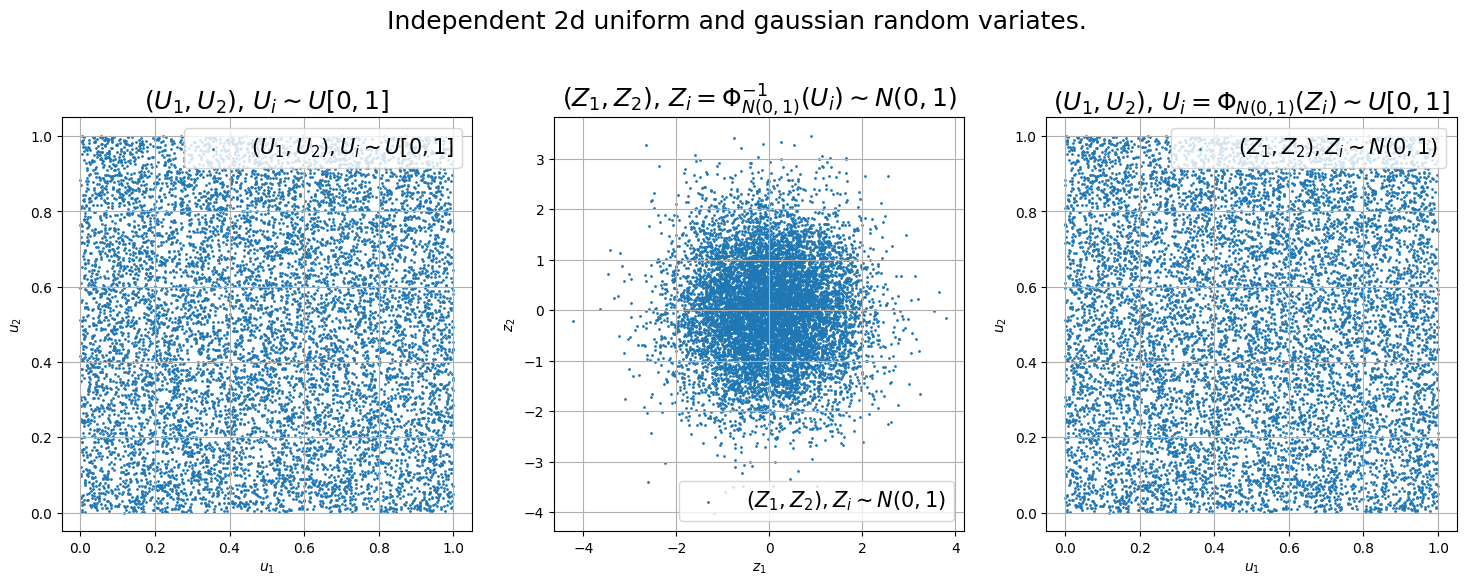

In [491]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
plt.rcParams.update({'font.size': 15, "axes.labelsize": 15})

ax[0].scatter(sample_of_independent_uniform_variates[:, 0], sample_of_independent_uniform_variates[:, 1], s=1, label="$(U_1, U_2), U_i \sim U[0,1]$")
ax[1].scatter(sample_of_independent_standard_gaussian_variates[:, 0], sample_of_independent_standard_gaussian_variates[:, 1], s=1, label="$(Z_1, Z_2), Z_i \sim N(0,1)$")
ax[2].scatter(sample_of_reversed_back_independent_uniform_variates[:, 0], sample_of_reversed_back_independent_uniform_variates[:, 1], s=1, label="$(Z_1, Z_2), Z_i \sim N(0,1)$")

plt.suptitle("Independent 2d uniform and gaussian random variates.")
plt.subplots_adjust(top=0.8)

ax[0].set_title("$(U_1, U_2)$, $U_i \sim U[0,1]$"), ax[0].set_xlabel('$u_1$'), ax[0].set_ylabel('$u_2$'), ax[0].legend()
ax[1].set_title("$(Z_1, Z_2)$, $Z_i = \Phi^{-1}_{N(0, 1)}(U_i) \sim N(0, 1)$"), ax[1].set_xlabel('$z_1$'), ax[1].set_ylabel('$z_2$'), ax[1].legend()
ax[2].set_title("$(U_1, U_2)$, $U_i = \Phi_{N(0, 1)}(Z_i) \sim U[0, 1]$"), ax[2].set_xlabel('$u_1$'), ax[2].set_ylabel('$u_2$'), ax[2].legend()
ax[0].grid(), ax[1].grid(), ax[2].grid()
plt.show()

In [493]:
def cholesky_decomposition(x: np.ndarray):
    return np.linalg.cholesky(x)

In [494]:
corr_matrix = np.array([[1, 0.8], [0.8, 1]])
square_root = cholesky_decomposition(x=corr_matrix)

In [496]:
print("Correlation matrix C: \n {} \n".format(corr_matrix))
print("Square root L of C: \n {} \n".format(square_root))

Correlation matrix C: 
 [[1.  0.8]
 [0.8 1. ]] 

Square root L of C: 
 [[1.  0. ]
 [0.8 0.6]] 



In [497]:
corr_coef = corr_matrix[0][1]

In [498]:
size = corr_matrix.shape[0]
sample_of_independent_uniform_variates = sample_independent_uniform_variates(n_sample=10000, size=size)
sample_of_independent_standard_gaussian_variates = transform_uniform_to_gaussian(uniform_sample=sample_of_independent_uniform_variates)
square_root_matrix = cholesky_decomposition(x=corr_matrix)
sample_of_codependent_standard_gaussian_variates =  sample_of_independent_standard_gaussian_variates @ square_root_matrix.T
sample_of_codependent_uniform_variates = transform_gaussian_to_uniform(gaussian_sample=sample_of_codependent_standard_gaussian_variates)

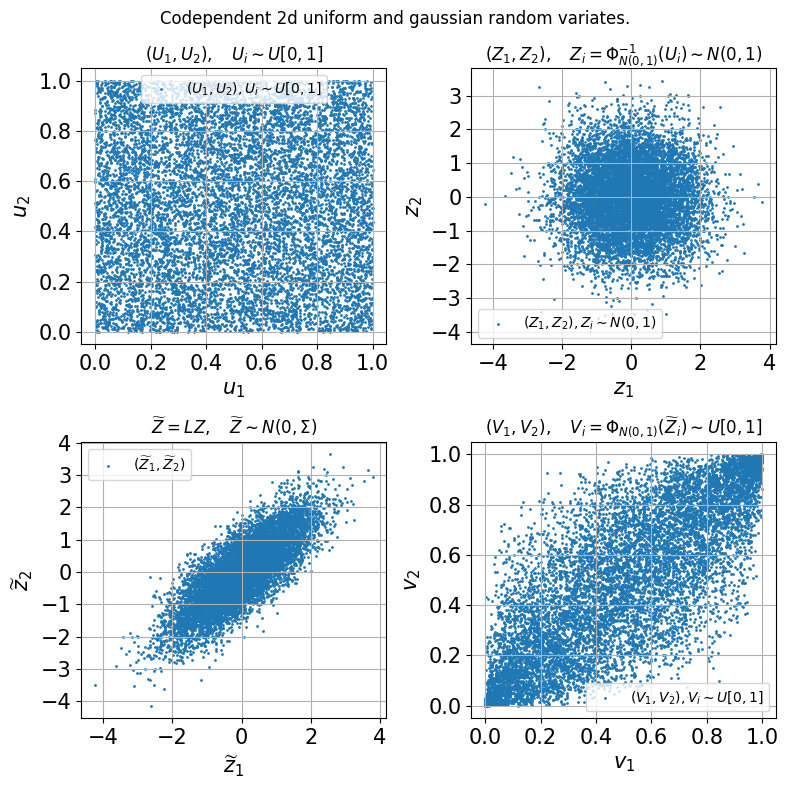

In [499]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
plt.rcParams.update({'font.size': 10, "axes.labelsize": 10})

ax[0][0].scatter(sample_of_independent_uniform_variates[:, 0], sample_of_independent_uniform_variates[:, 1], s=1, label="$(U_1, U_2), U_i \sim U[0,1]$")
ax[0][1].scatter(sample_of_independent_standard_gaussian_variates[:, 0], sample_of_independent_standard_gaussian_variates[:, 1], s=1, label="$(Z_1, Z_2), Z_i \sim N(0,1)$")
ax[1][0].scatter(sample_of_codependent_standard_gaussian_variates[:, 0], sample_of_codependent_standard_gaussian_variates[:, 1], s=1, label="$(\\widetilde Z_1, \\widetilde Z_2)$")
ax[1][1].scatter(sample_of_codependent_uniform_variates[:, 0], sample_of_codependent_uniform_variates[:, 1], s=1, label="$(V_1, V_2), V_i \sim U[0,1]$")

plt.suptitle("Codependent 2d uniform and gaussian random variates.")
plt.subplots_adjust(top=0.9)

ax[0][0].set_title("$(U_1, U_2), \quad U_i \sim U[0,1]$"), ax[0][0].set_xlabel('$u_1$'), ax[0][0].set_ylabel('$u_2$'), ax[0][0].legend()
ax[0][1].set_title("$(Z_1, Z_2), \quad Z_i = \Phi^{-1}_{N(0, 1)}(U_i) \sim N(0, 1)$"), ax[0][1].set_xlabel('$z_1$'), ax[0][1].set_ylabel('$z_2$'), ax[0][1].legend()
ax[1][0].set_title("$\\widetilde Z = LZ, \quad \\widetilde Z \sim N(0, \Sigma)$"), ax[1][0].set_xlabel('$\\widetilde z_1$'), ax[1][0].set_ylabel('$\\widetilde z_2$'), ax[1][0].legend()
ax[1][1].set_title("$(V_1, V_2), \quad V_i = \Phi_{N(0, 1)}(\\widetilde Z_i) \sim U[0, 1]$"), ax[1][1].set_xlabel('$v_1$'), ax[1][1].set_ylabel('$v_2$'), ax[1][1].legend()
ax[0][0].grid(), ax[0][1].grid(), ax[1][0].grid(), ax[1][1].grid()
fig.tight_layout()
plt.show()

#### 1.4 Monte-Carlo integration

Recall that we are dealing with computation of the following integral 

$$\mathbb{E}g(X_1, \dots, X_n) = \int_{\mathbb{R}^n} g(X_1, \dots, X_n) dH(X_1, \dots, X_n),$$

where $H(X_1, \dots, X_n)$ is a joint distribution function of $X_1, \dots, X_n$.

Applying Sklar's theorem, $H$ can be represented by some copula $C$, i.e. 

$$H(x_1, \dots, x_n) = C(F_1(x_1), \dots, F_n(x_n)).$$

Therefore, the expectation from above can be written as 

$$\mathbb{E}g(X_1, \dots, X_n) = \int_{[0, 1]^n} g(F^{-1}_1(u_1), \dots, F^{-1}_n(u_n)) dC(u_1, \dots, u_n).$$

Finally, the expectation can be estimated through the following Monte-Carlo algorithm

For each $k = 1, \dots, N$, 
1. Draw a $k$-th sample $(U^k_1, \dots, U^k_n)$ from the copula $C$. 

2. Set $(X^k_1, \dots, X^k_n) = (F^{-1}_1(U^k_1), \dots, F^{-1}_n(U^k_n))$.

Approximate $\mathbb{E}g(X_1, \dots, X_n)$ by its empirical analogue 

$$\mathbb{E}g(X_1, \dots, X_n) \approx \dfrac{1}{N} \sum_{k=1}^{N} g(X^k_1, \dots, X^k_n).$$

The rate of convergence due to central limit theorem is $1/\sqrt{N}$.

**Example**

Let $S_1$ and $S_2$ be two gaussian random variables with correlation coefficient $\rho$. How we may compute their cross moment? We use the 2d Gaussian copula with covariance matrix equal to 

$$
\begin{align*}
\Sigma = 
\left(
\begin{matrix} 
1 & \rho \\ 
\rho & 1 \\
\end{matrix}
\right)
\end{align*}.
$$



$$\mathbb{E}S_1 S_2 = \int_{\mathbb{R}^n} S_1 S_2 dH(S_1, S_2) = \int_{[0, 1]^2} F^{-1}_1(u_1) F^{-1}_2(u_2) dC(u_1, u_2).$$

For each $k = 1, \dots, N$, 
1. Draw a $k$-th sample $(U^k_1, U^k_2)$ from the Gaussian copula $C$. 

2. Set $(X^k_1, X^k_2) = (F^{-1}_1(U^k_1),F^{-1}_2(U^k_2))$.

Approximate $\mathbb{E} S_1 S_2$ by its empirical analogue 

$$\mathbb{E} S_1 S_2 \approx \dfrac{1}{N} \sum_{k=1}^{N} X^k_1 X^k_2.$$


In [501]:
def gaussian_copula(n_sample: int, corr_matrix: np.ndarray):
    size = corr_matrix.shape[0]
    sample_of_independent_uniform_variates = sample_independent_uniform_variates(n_sample=n_sample, size=size)
    sample_of_independent_standard_gaussian_variates = transform_uniform_to_gaussian(uniform_sample=sample_of_independent_uniform_variates)
    square_root_matrix = cholesky_decomposition(x=corr_matrix)
    sample_of_codependent_standard_gaussian_variates =  sample_of_independent_standard_gaussian_variates @ square_root_matrix.T
    sample_of_codependent_uniform_variates = transform_gaussian_to_uniform(gaussian_sample=sample_of_codependent_standard_gaussian_variates)
    return sample_of_codependent_uniform_variates
    

In [502]:
sample_of_codependent_uniform_variates = gaussian_copula(n_sample=2**19, corr_matrix=corr_matrix)
sample_of_transformed_back_codependent_gaussian_variates =  transform_uniform_to_gaussian(uniform_sample=sample_of_codependent_uniform_variates)

In [503]:
def first_moment(sample_of_gaussian_variates: np.ndarray):
    return np.mean(sample_of_gaussian_variates)

def second_moment(sample_of_gaussian_variates: np.ndarray):
    return np.std(sample_of_gaussian_variates)

def cross_moment(sample_of_gaussian_variates_1: np.ndarray, sample_of_gaussian_variates_2: np.ndarray):
    return np.mean(sample_of_gaussian_variates_1 * sample_of_gaussian_variates_2)

In [504]:
def convergence_analysis(sample_of_codependent_gaussian_variates: np.ndarray, true_results: np.ndarray):
    maximum_number_of_iterations = sample_of_codependent_gaussian_variates.shape[0]
    results = np.zeros((int(np.log2(maximum_number_of_iterations)), 3))
    for i in range(results.shape[0]):
        results[i, 0] = np.abs(first_moment(sample_of_gaussian_variates=sample_of_codependent_gaussian_variates[:2**i, 1]) - true_results[0])
        results[i, 1] = np.abs(second_moment(sample_of_gaussian_variates=sample_of_codependent_gaussian_variates[:2**i, 1]) - true_results[1])
        results[i, 2] = np.abs(cross_moment(sample_of_gaussian_variates_1=sample_of_codependent_gaussian_variates[:2**i, 0], 
                                         sample_of_gaussian_variates_2=sample_of_codependent_gaussian_variates[:2**i, 1]) - true_results[2])
    return results


In [505]:
convergence_result = convergence_analysis(sample_of_codependent_gaussian_variates=sample_of_transformed_back_codependent_gaussian_variates, 
                                          true_results=np.array([0, 1, corr_matrix[0][1]]))

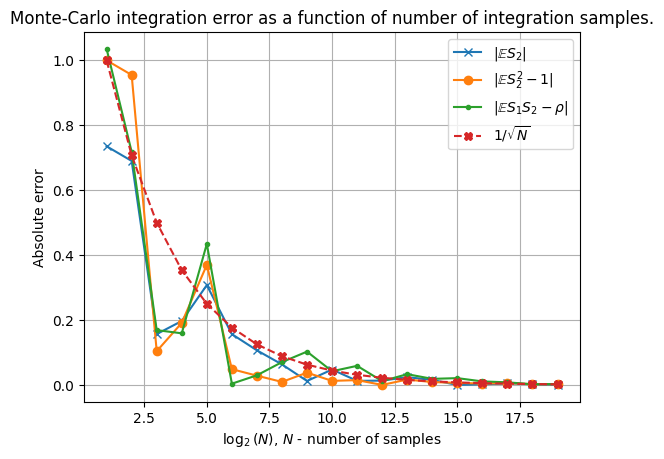

In [506]:
log_2_iteratinos = np.linspace(1, 19, 19)
one_over_sqrt_N = 1 / np.sqrt([2**i for i in range(log_2_iteratinos.shape[0])])
one_over_sqrt_N
plt.plot(log_2_iteratinos, convergence_result[:, 0], label="$|\mathbb{E}S_2|$", marker="x")
plt.plot(log_2_iteratinos, convergence_result[:, 1], label="$|\mathbb{E} S_2^2 - 1|$", marker="o")
plt.plot(log_2_iteratinos, convergence_result[:, 2], label="$|\mathbb{E} S_1S_2 - \\rho|$", marker=".")
plt.plot(np.linspace(1, 19, 19), one_over_sqrt_N, label="$1/\sqrt{N}$", marker="X", linestyle="--")
plt.title('Monte-Carlo integration error as a function of number of integration samples.')
plt.xlabel("$\log_2(N)$, $N$ - number of samples")
plt.ylabel("Absolute error")
plt.legend()
plt.grid()
plt.show()

### References

1. Jaeckel, Peter. “Monte Carlo methods in finance.” (2002).

2. Богачев, Практикум на ЭВМ. Методы решения линейных систем и нахождения собственных значений. (1998)

3. https://docs.scipy.org/doc/scipy/tutorial/linalg.html